# Fibril Generator and CyRSoXS Simulation

In [2]:
from scipy.interpolate import interp1d
from scipy.ndimage import rotate
from sklearn.preprocessing import normalize
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import trimesh
import pyembree
import random
import pickle
from NRSS.writer import write_materials, write_hdf5, write_config, write_slurm
from NRSS.checkH5 import checkH5

from Morphology import Morphology
from Fibril import Fibril
import sys
import pathlib


import subprocess
import h5py

from PyHyperScattering.load import cyrsoxsLoader
from PyHyperScattering.integrate import WPIntegrator


import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib import cm
from matplotlib.colors import LogNorm

import numpy as np
import io
from PIL import Image
import PIL


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define path to NRSS and PyHyperScattering

In [3]:
sys.path.append('/home/devon/Documents/Github/NRSS/')
sys.path.append('/home/devon/Documents/Github/PyHyperScattering/src/')

## Define and generate fibril morphology

In [5]:
# Declare model box size in nm (x,y,z)
x_dim_nm  = 1024
y_dim_nm  = 1024
z_dim_nm  = 128
pitch_nm = 2 # Dimension of voxel in nm

# Initialize morphology
morphology = Morphology(x_dim_nm, y_dim_nm, z_dim_nm, pitch_nm)
morphology.set_model_parameters(radius_nm_avg = 12,
                                radius_nm_std = 3,
                                max_num_fibrils = 200,
                                fibril_length_range_nm = [100, 400])

morphology.fill_model()

-- Fibril 0 --
-- Fibril 1 --
-- Fibril 2 --
-- Fibril 3 --
-- Fibril 4 --
-- Fibril 5 --
-- Fibril 6 --
-- Fibril 7 --
-- Fibril 8 --
-- Fibril 9 --
-- Fibril 10 --
-- Fibril 11 --
-- Fibril 12 --
-- Fibril 13 --
-- Fibril 14 --
-- Fibril 15 --
-- Fibril 16 --
-- Fibril 17 --
-- Fibril 18 --
-- Fibril 19 --
-- Fibril 20 --
-- Fibril 21 --
-- Fibril 22 --
-- Fibril 23 --
-- Fibril 24 --
-- Fibril 25 --
-- Fibril 26 --
-- Fibril 27 --
-- Fibril 28 --
-- Fibril 29 --
-- Fibril 30 --
-- Fibril 31 --
-- Fibril 32 --
-- Fibril 33 --
-- Fibril 34 --
-- Fibril 35 --
-- Fibril 36 --
-- Fibril 37 --
-- Fibril 38 --
-- Fibril 39 --
-- Fibril 40 --
-- Fibril 41 --
-- Fibril 42 --
-- Fibril 43 --
-- Fibril 44 --
-- Fibril 45 --
-- Fibril 46 --
-- Fibril 47 --
-- Fibril 48 --
-- Fibril 49 --
-- Fibril 50 --
-- Fibril 51 --
-- Fibril 52 --
-- Fibril 53 --
-- Fibril 54 --
-- Fibril 55 --
-- Fibril 56 --
-- Fibril 57 --
-- Fibril 58 --
-- Fibril 59 --
-- Fibril 60 --
-- Fibril 61 --
-- Fibril 62 --
--

-- Fibril 183 --
-- Fibril 184 --
-- Fibril 185 --
-- Fibril 186 --
-- Fibril 187 --
-- Fibril 188 --
-- Fibril 189 --
-- Fibril 190 --
-- Fibril 191 --
-- Fibril 192 --
-- Fibril 193 --
-- Fibril 194 --
-- Fibril 195 --


-- Fibril 196 --
-- Fibril 197 --
-- Fibril 198 --
-- Fibril 199 --


In [ ]:
# May not show if the morphology is too large (too many fibrils)
scene = morphology.get_scene(show_bounding_box=True)
scene.show()

In [8]:
morphology.voxelize_model()

## Save voxelized morphology as reduced morphology

In [299]:
from ReducedMorphology import ReducedMorphology
rm = ReducedMorphology(morphology)

In [303]:
rm.pickle()

## Load voxelized reduced morphology

In [304]:
rm = None
filename = '1024x1024x128nm_pitch2nm_rad12nm_std3nm_200fib_length100-400nm.pickle'
with open(filename, 'rb') as f:
    rm = pickle.load(f)

## Create material matricies

In [310]:
from PostProcessing import generate_material_matricies
# Edit post processing parameters in PostProcessing.py
mat_Vfrac, mat_S, mat_theta, mat_psi = generate_material_matricies(rm)

## Generate simulation input files

In [311]:
phys_size = 2.0
write_hdf5([[mat_Vfrac[0], mat_S[0], mat_theta[0], mat_psi[0]], 
            [mat_Vfrac[1], mat_S[1], mat_theta[1], mat_psi[1]],
            [mat_Vfrac[2], mat_S[2], mat_theta[2], mat_psi[2]]],
            phys_size, 'Fibril.hdf5')

--> Marking Fibril.hdf5


'Fibril.hdf5'

Dataset dimensions (Z, Y, X): 64 x 512 x 512
Number of Materials: 3

Material 1 Vfrac. Min: 0.0 Max: 1.0
Material 1 S. Min: 0.0 Max: 0.0
Material 1 theta. Min: 0.0 Max: 0.0
Material 1 psi. Min: 0.0 Max: 0.0


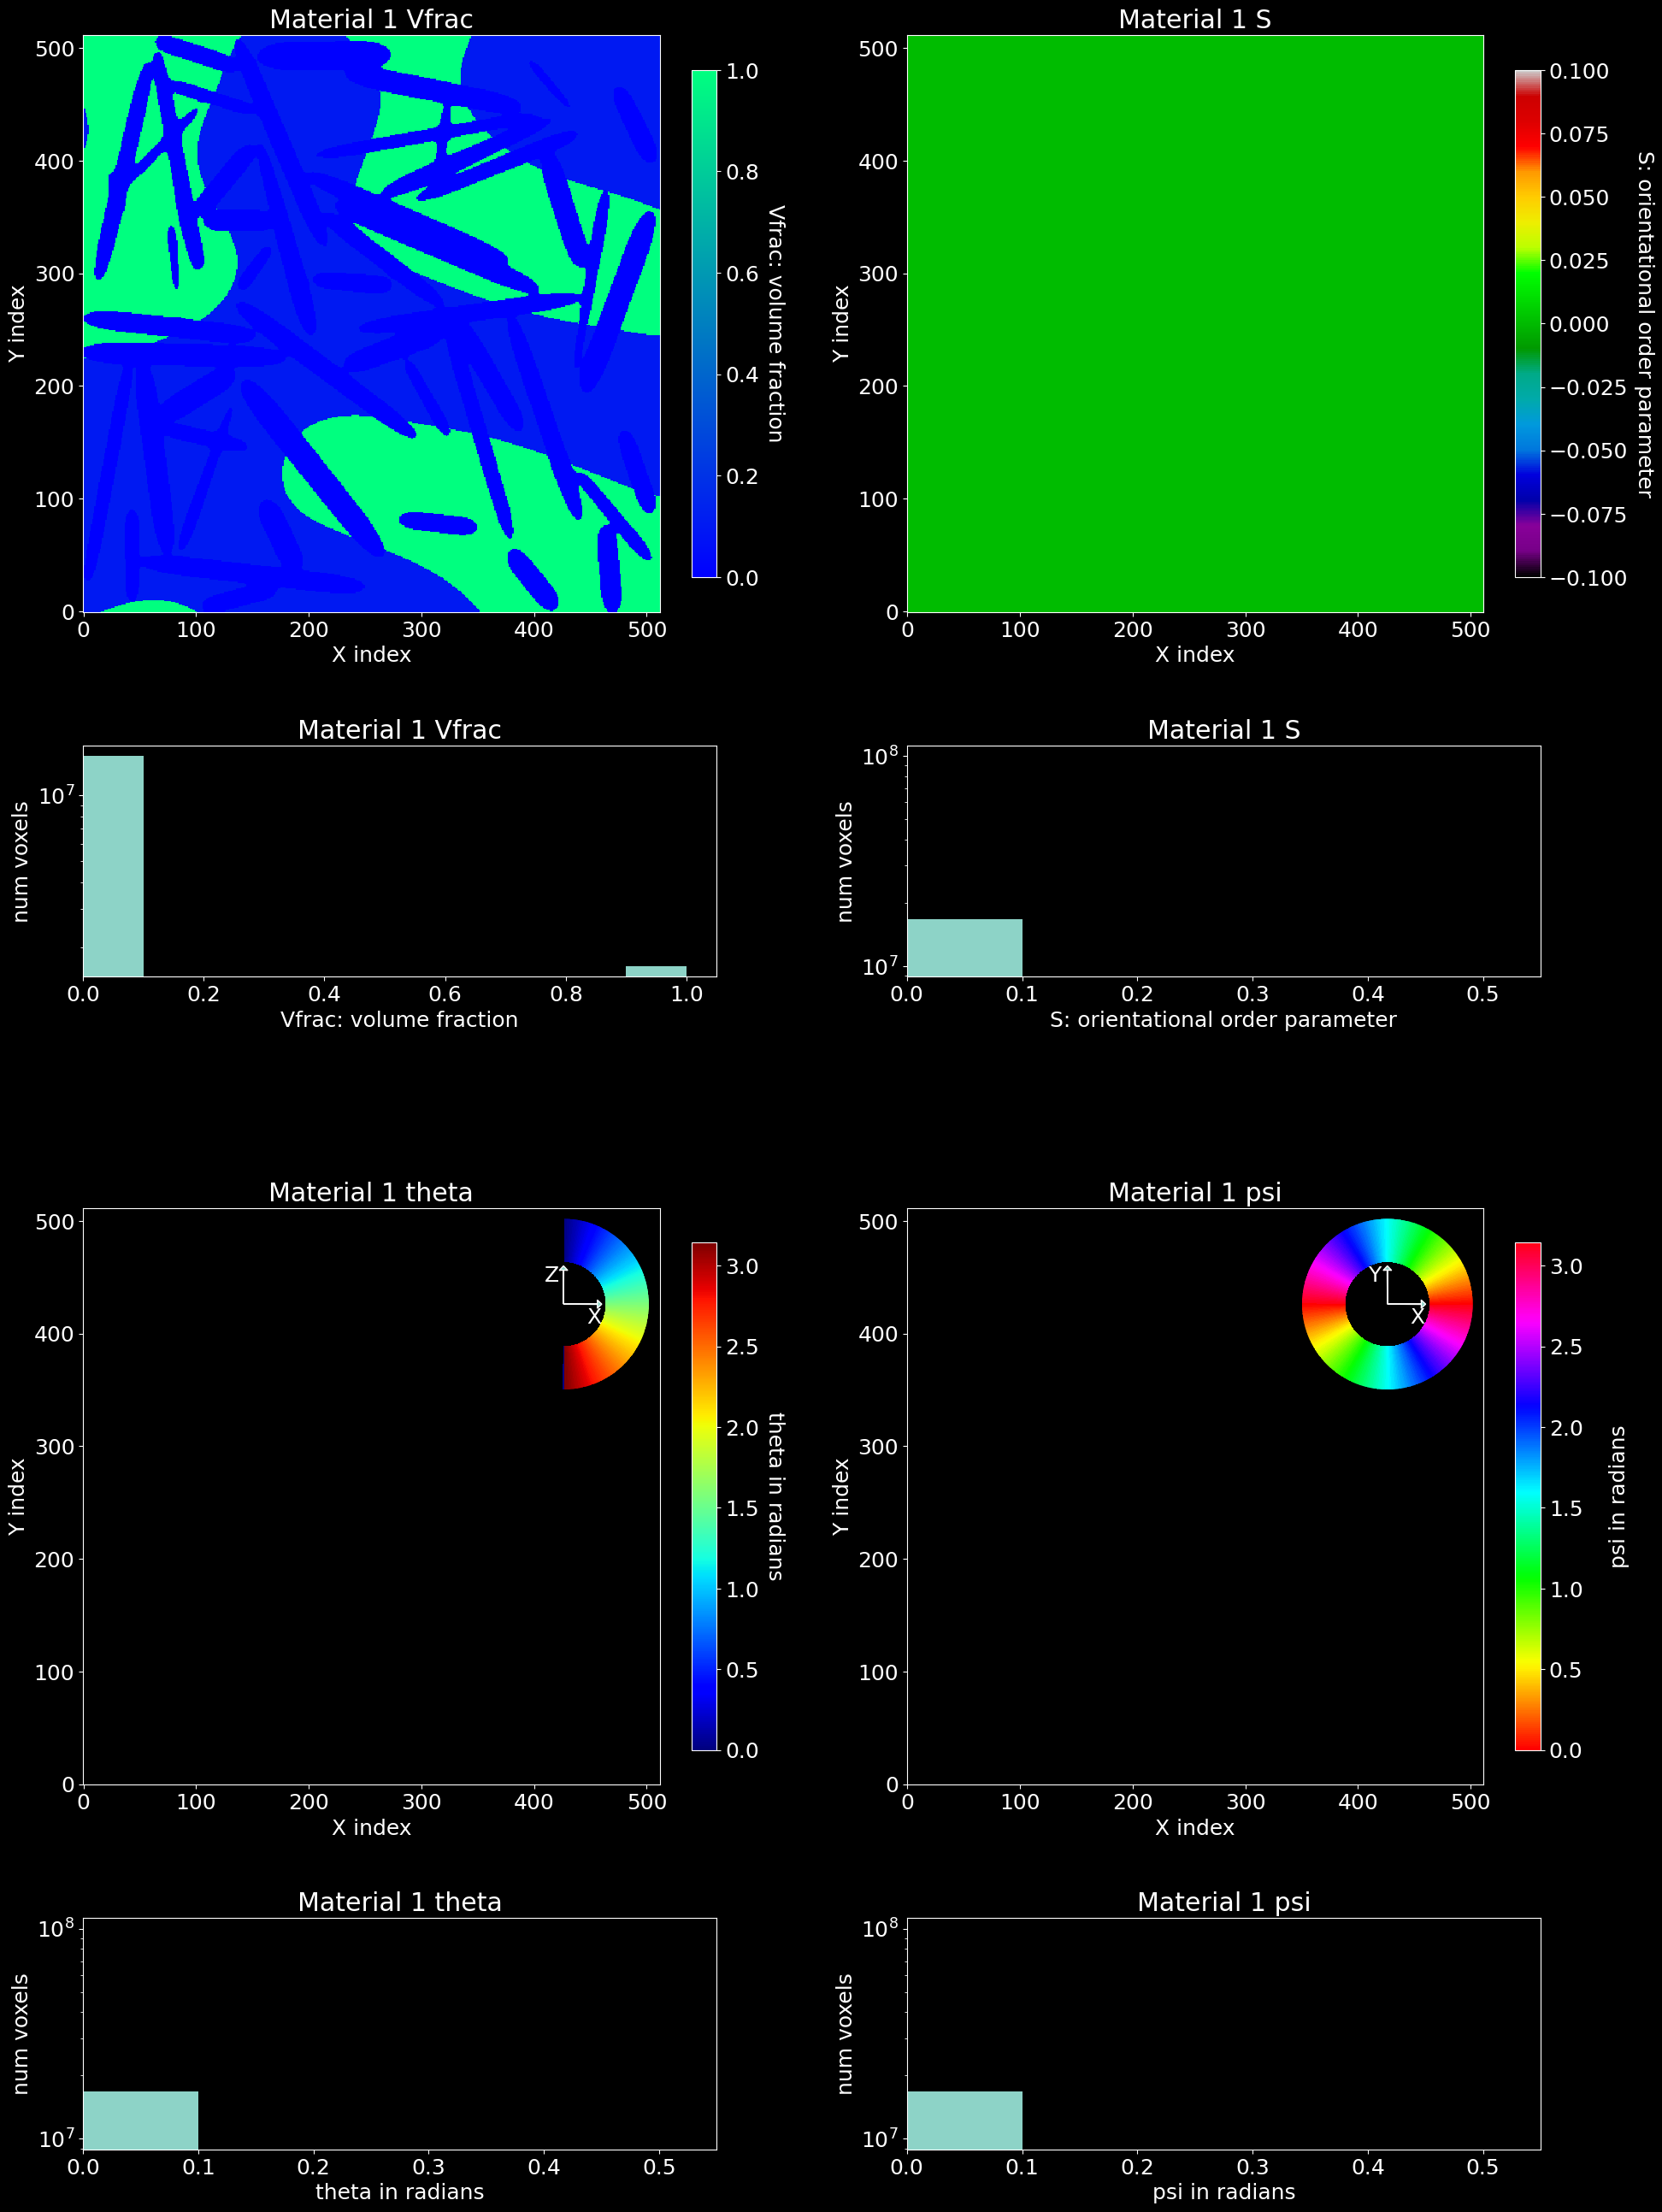

Material 2 Vfrac. Min: 0.0 Max: 1.0
Material 2 S. Min: 0.0 Max: 1.0
Material 2 theta. Min: 0.0 Max: 1.6176459530383667
Material 2 psi. Min: 0.0 Max: 3.1318168736775496


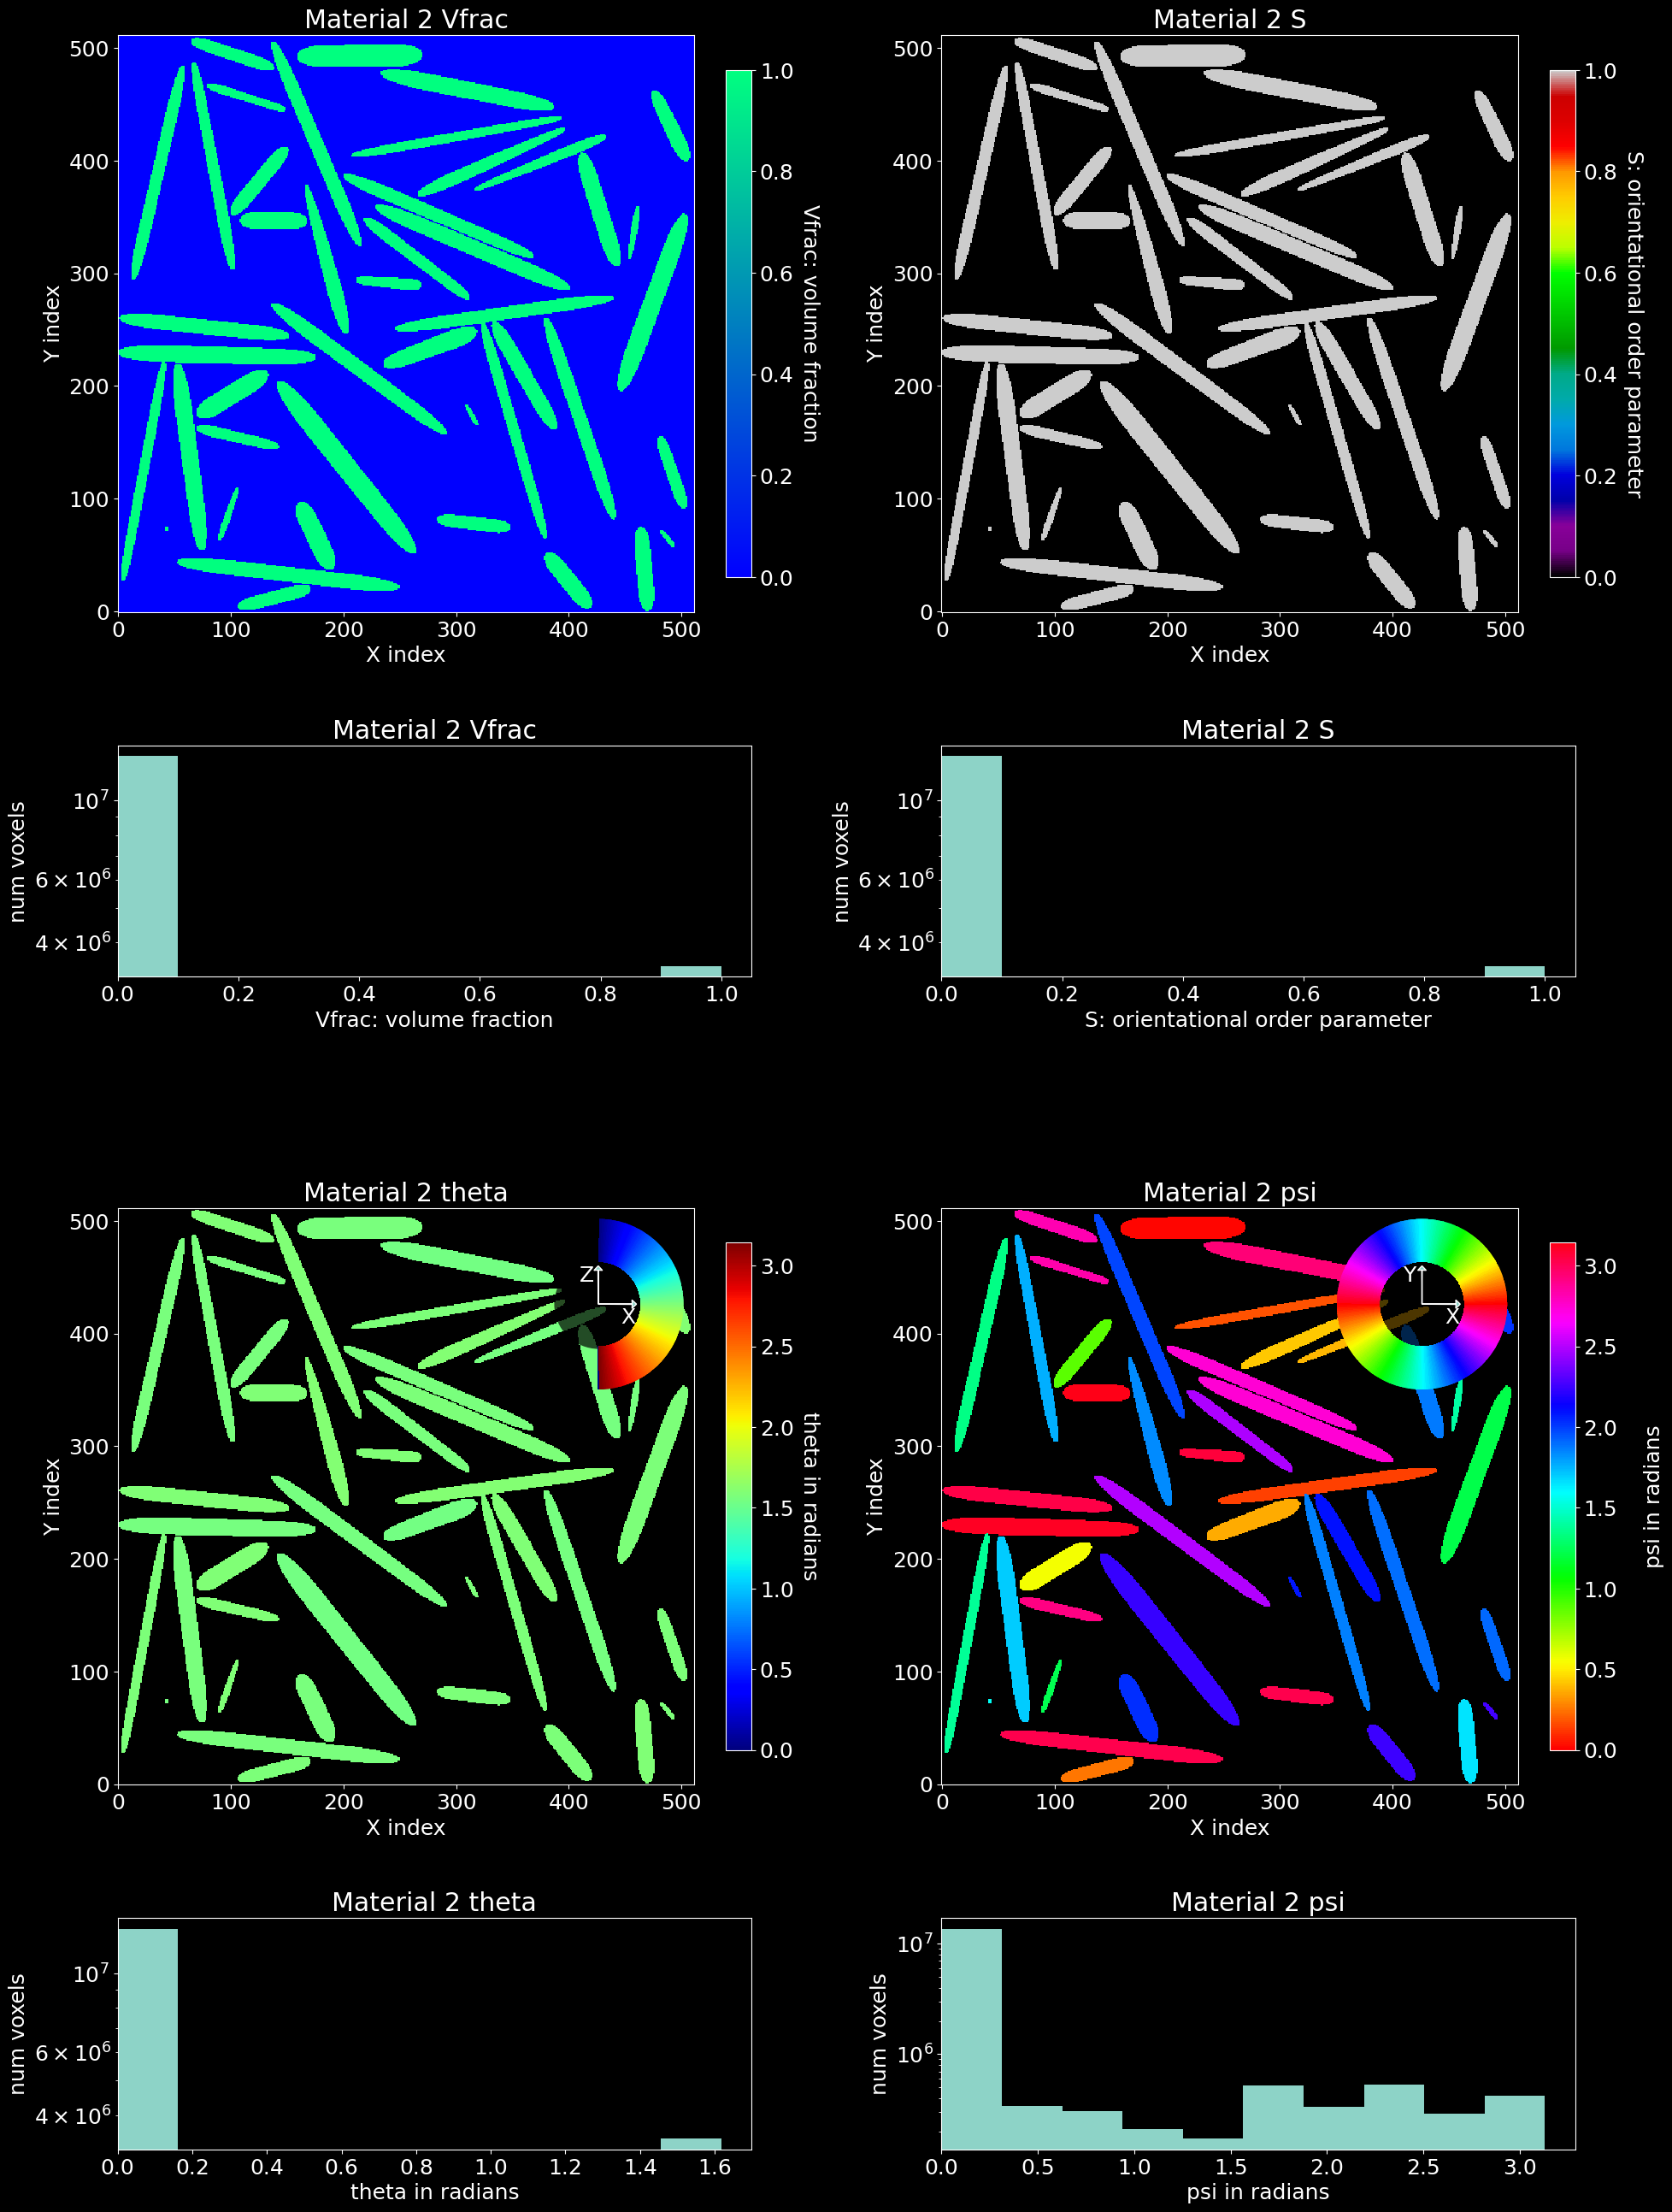

Material 3 Vfrac. Min: 0.0 Max: 1.0
Material 3 S. Min: 0.0 Max: 0.0
Material 3 theta. Min: 0.0 Max: 0.0
Material 3 psi. Min: 0.0 Max: 0.0


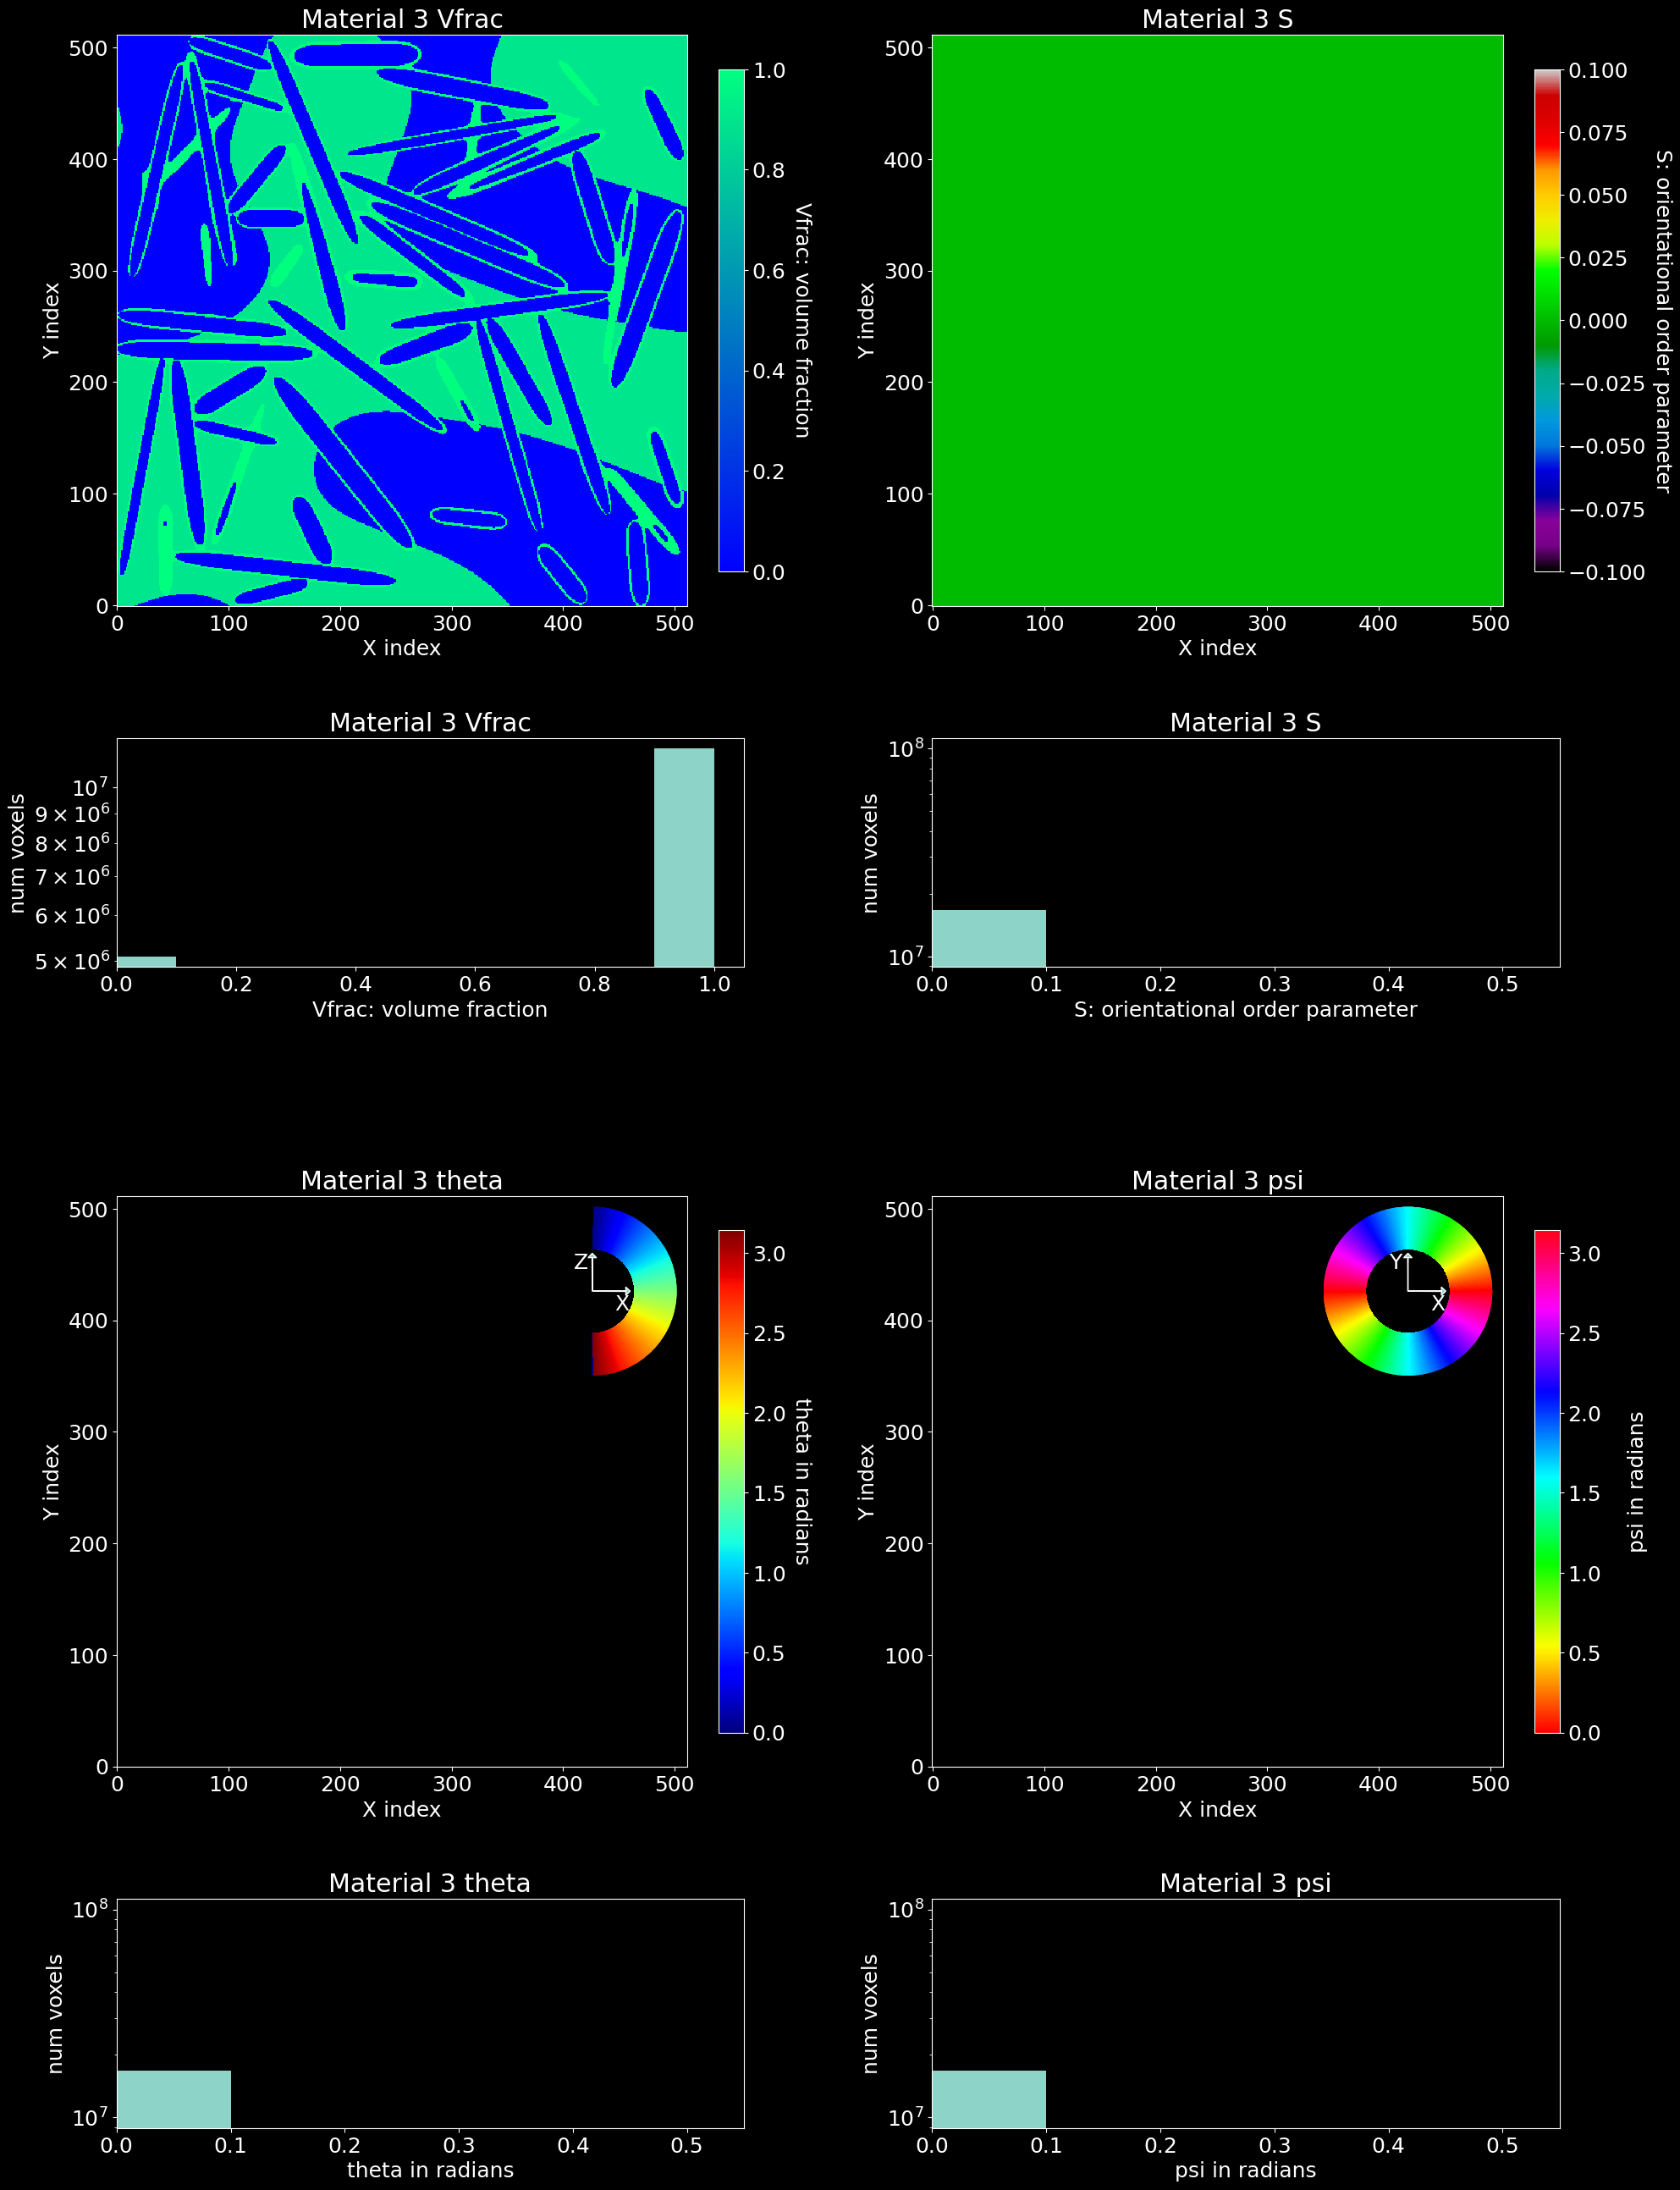

Total Vfrac whole model. Min: 1.0 Max: 1.0
0:00:08.035704


In [312]:
checkH5('Fibril.hdf5', z_slice=55, plotstyle='dark')

In [275]:
energies = np.round(np.arange(280., 300., 1),1)
energies

array([280., 281., 282., 283., 284., 285., 286., 287., 288., 289., 290.,
       291., 292., 293., 294., 295., 296., 297., 298., 299.])

In [276]:
# material_dict = {'Material1':'P3HT.txt', 'Material2':'vacuum'}
material_dict = {'Material1': 'vacuum', 'Material2': 'P3HT.txt', 'Material3': 'P3HT.txt'}
energy_dict = {'Energy':6,'DeltaPerp':3, 'BetaPerp':1, 'DeltaPara':2, 'BetaPara':0}  
write_materials(energies, material_dict, energy_dict, 3)

In [278]:
write_config(list(energies), [0.0, 1.0, 360.0], CaseType=0, MorphologyType=0)

## Run CyRSoXS

In [279]:
subprocess.run(['CyRSoXS','Fibril.hdf5'])

[WARNING] : No value corresponding to HDF5DirName found. Setting to default
[WARNING] : No value corresponding to Algorithm found. Setting to default
[WARNING] : No value corresponding to MaxStreams found. Setting to default
Input Data : [OK] 
NumMaterial          : 3
Dimensions [Z Y X]   : [64 512 512]
PhysSize             : 2 nm 
E Rotation Angle     : 0 : 1 : 360
Morphology Type      : EulerAngles
Morphology Order     : ZYX
Energies simulated   : [280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 ]
Windowing Type       : NONE
Rotation Mask        : 0
Interpolation Type   : Trilinear interpolation
HDF Output Directory : HDF5
Scatter Approach     : Partial
Algorithm            : CommunicationMinimizing
 __________________________________________________________________________________________________
|                                 Thanks for using CyRSoXS                                        |
|--------------------------------------------------------

CompletedProcess(args=['CyRSoXS', 'Fibril.hdf5'], returncode=0)

## Load CyRSoXS Results

In [280]:
basePath = pathlib.Path('.').absolute()
h5path = pathlib.Path(basePath,'HDF5')
h5list = list(sorted(h5path.glob('*h5')))

In [281]:
def print_key(f, key):
    try:
        keys2 = f[key].keys()
        for key2 in keys2:
            new_key = key + '/' + key2
            print_key(f, new_key)
    except AttributeError:
        print(key)

with h5py.File(h5list[0],'r') as f:
    for key in f.keys():
        print_key(f, key)

K0/projection
KIDList/KVec


In [282]:
load = cyrsoxsLoader()
integ = WPIntegrator(force_np_backend=True) # avoiding gpu backend for this tutorial

In [283]:
raw = load.loadDirectory(basePath)

Finished reading 20 energies. Time required: 0:00:00.023912


In [284]:
remeshed = integ.integrateImageStack(raw)

  0%|          | 0/20 [00:00<?, ?it/s]

## Visualize CyRSoXS Results

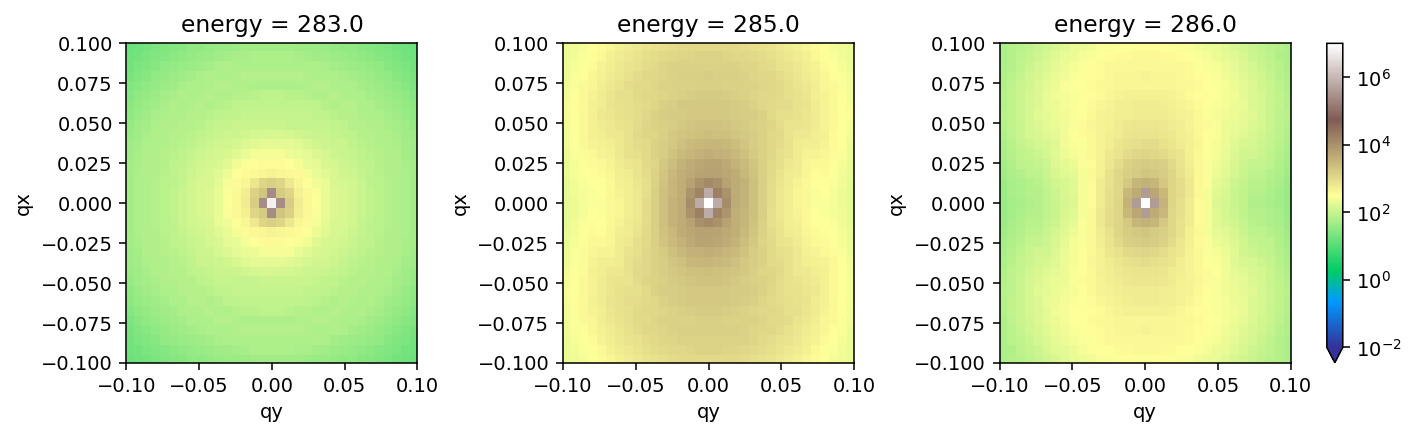

In [286]:
c = cm.jet(np.linspace(0,1,len(remeshed)))
fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=140,constrained_layout=True)
raw.sel(energy=283).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[0],add_colorbar=False)
raw.sel(energy=285).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[1],add_colorbar=False)
raw.sel(energy=286).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[2])

[{axes.set_xlim(-0.1,0.1),axes.set_ylim(-0.1,0.1)} for axes in ax]
plt.show()

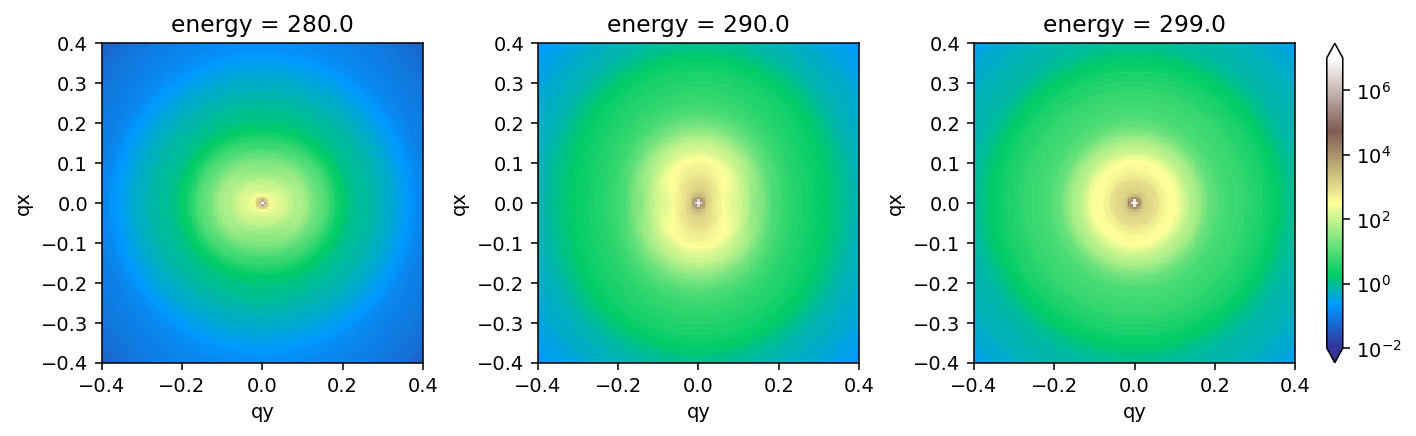

In [287]:
fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=140,constrained_layout=True)
raw.sel(energy=280).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[0],add_colorbar=False)
raw.sel(energy=290).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[1],add_colorbar=False)
raw.sel(energy=299).plot(norm=LogNorm(1e-2,1e7),cmap='terrain',ax=ax[2])

[{axes.set_xlim(-0.4,0.4),axes.set_ylim(-0.4,0.4)} for axes in ax]
plt.show()

In [288]:
# calculate the anisotropy metric
A = remeshed.rsoxs.AR(chi_width=20)

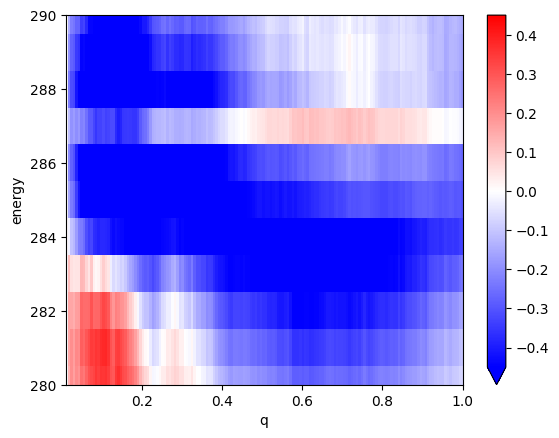

In [314]:
A.plot(x='q',cmap='bwr', vmin=-0.45, vmax=0.45)
plt.xlim(left=0.01, right=1)
plt.ylim(bottom=280, top=290)
plt.xscale('linear')
plt.show()

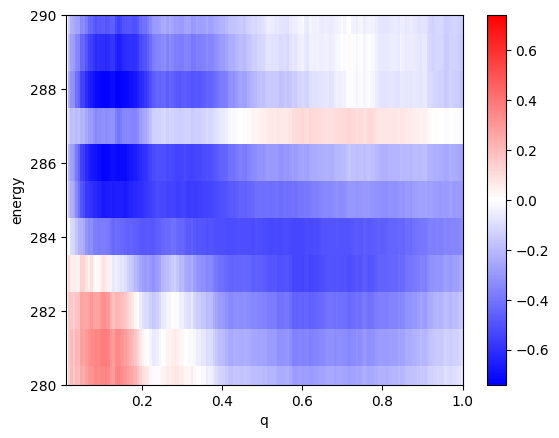

In [315]:
A.plot(x='q',cmap='bwr')
plt.xlim(left=0.01, right=1)
plt.ylim(bottom=280, top=290)
plt.xscale('linear')
plt.show()

In [316]:
horz = remeshed.rsoxs.slice_chi(0, chi_width=20)
vert = remeshed.rsoxs.slice_chi(90, chi_width=20)

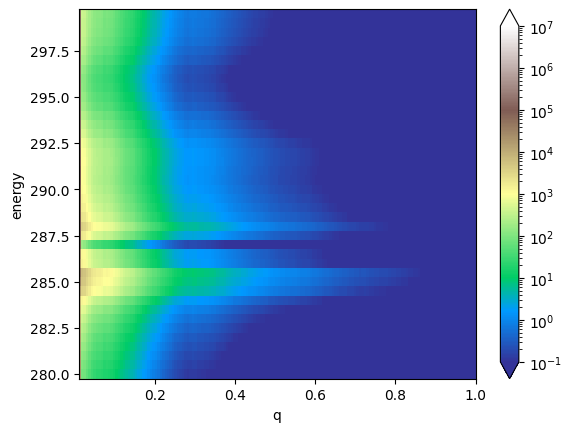

In [223]:
vert.plot(x='q',cmap='terrain',norm=LogNorm(1e-1,1e7), xscale='linear')
plt.xlim(left=0.01, right=1)
plt.show()

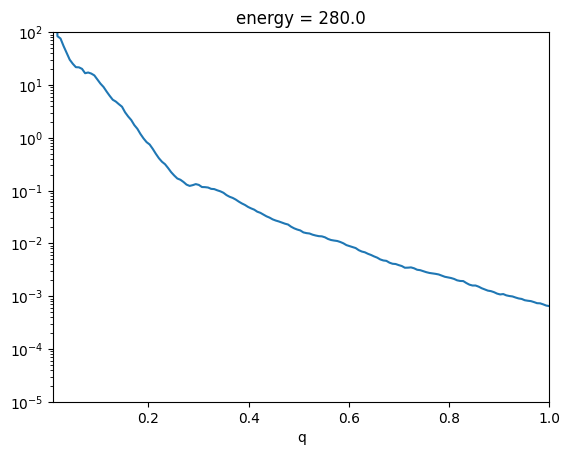

In [224]:
vert.sel(energy=280).plot(yscale='log',xscale='linear')
plt.xlim(left=0.01, right=1)
plt.ylim(bottom=1e-5, top=1e2)
plt.show()